In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from plane_nerf.inerf_trainer import load_data_into_trainer
from plane_nerf.inerf_utils import inerf_v2
from plane_nerf.inerf_utils import load_eval_image_into_pipeline, get_corrected_pose, transform_original_space_to_pose
from scipy.spatial.transform import Rotation 


In [33]:
os.chdir('/workspace/plane-nerf')
MODEL_PATH = "/workspace/plane-nerf/outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148"
DATA_PATH = "/stored_data/jackal_one_frame"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )
transform_file_path = "transforms.json"
with open(os.path.join(DATA_PATH, transform_file_path)) as f:
    transform = json.load(f)

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,transform)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 40
trainer.pipeline.datamanager.METHOD = "sift"

tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Fal

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148/nerfstudio_models/step-000009999.ckpt

Setting up training dataset...

Caching all 1 images.

Loading PlaneNerfCameraOptimizer


[11:46:57] Saving checkpoints to:                                                                         ]8;id=121092;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=79540;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#136\136]8;;\
           outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148/nerfstudio_models                     

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_floor_training_data_1/plane-nerf-fast/2024-03-18_221148/nerfstudio_models/step-000009999.ckpt

In [34]:
for camera, batch in pipeline.datamanager.fixed_indices_train_dataloader:
    break

In [48]:
correction = get_corrected_pose(trainer).squeeze(0)
#Add a row to correction
#correction = torch.cat((correction, torch.tensor([[0, 0, 0, 1]]).to(trainer.device).float()))
#correction = correction.inverse().unsqueeze(0)
print(correction)
n = 10

store_img = []

for r in range(n):
    angle = r / n * 2 * np.pi
    rotation = Rotation.from_euler('Z', angle).as_matrix()    
    rotation = torch.tensor(rotation).unsqueeze(0).float().to(trainer.device)

    new_pose = rotation @ correction
    #new_pose = new_pose.inverse()
    new_pose = transform_original_space_to_pose(new_pose,                                                   
                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_transform.to(trainer.device),
                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
                                                "opengl")
    
    camera.camera_to_worlds = new_pose
    outputs = pipeline.model.get_outputs_for_camera(camera=camera)    
    store_img.append(outputs["rgb"])


tensor([[ 0.8717,  0.3331, -0.3593, -1.5590],
        [-0.4895,  0.6245, -0.6086, -2.3829],
        [ 0.0217,  0.7064,  0.7075,  2.5000]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


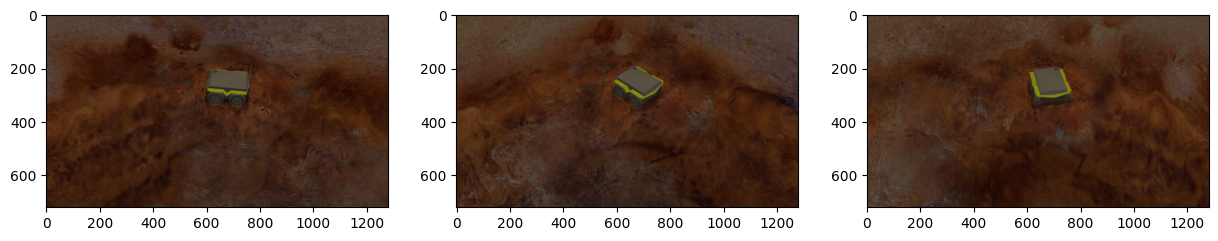

In [50]:
#Plt 3 images
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(store_img[1].cpu())
plt.subplot(132)
plt.imshow(store_img[2].cpu())
plt.subplot(133)
plt.imshow(store_img[3].cpu())